# Analysing the CRA compensation of the Raspberry Pi Camera Module

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from extract_raw_image import load_raw_image
import sys
import os
from __future__ import print_function
%matplotlib notebook

In [6]:
data_folder = "./run_3/straight/"

## Load images and plot raw data
The images below are what is obtained from the sensor, under red, gree, and blue illumination.  Each column represents an illumination colour (white, red, green, then blue) and each row represents a colour channel in the image.  The final row is the RGB image, extracted from the raw data with minimal additional processing.

<IPython.core.display.Javascript object>


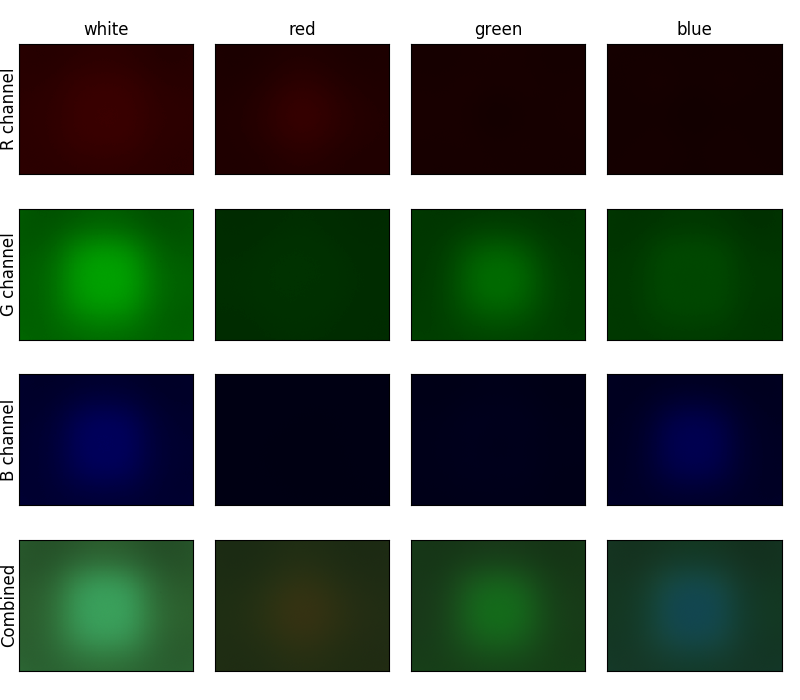

In [72]:
from matplotlib.colors import LinearSegmentedColormap

def bin(image, b=2):
    """Bin bxb squares of an image together"""
    w,h = image.shape[:2]
    new_shape = (w//b, b, h//b, b)
    if len(image.shape) > 2:
        new_shape += image.shape[2:]
    if w % b != 0 or h % b != 0:
        print("Warning: pixels are being dropped from the binned image!")
        image = image[:w - (w%b), :h - (h%b), ...]
    return image.reshape(new_shape).mean(axis=1).mean(axis=2)

illuminations = [(255,255,255), (255,0,0), (0,255,0), (0,0,255)]
binned_images = []

fig, ax = plt.subplots(4, 4, figsize=(8,7))
for i, rgb in enumerate(illuminations):
    pi_bayer_array = load_raw_image(os.path.join(data_folder, "capture_r{}_g{}_b{}.jpg".format(*rgb)))
    image = pi_bayer_array.array
    channels = ["red", "green", "blue"]
    for j, channel in enumerate(channels):
        cm = LinearSegmentedColormap(channel+"map",
                {c: [(0,0,0),(1,1,1)] if c==channel 
                    else [(0,0,0),(0.95,0,1),(1,1,1)] 
                    for c in channels})
        ax[j,i].imshow(bin(image[:,:,j],16), vmin=0, vmax=255, cmap=cm)
    binned_images.append(bin(image, 16))
    image_8bit = binned_images[-1].astype(np.uint8)
    ax[3,i].imshow(image_8bit)
    
for row in ax:
    for axis in row:
        # tidy up the plot (hide axes)
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)

def wrgb_col_titles(axes):
    for topax, title in zip(axes, ["white", "red", "green", "blue"]):
        topax.set_title(title)
def row_titles(axes, titles):
    for ax, title in zip(axes, titles):
        ax.annotate(title, xy=(0, 0.5), xytext=(0, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='left', va='center', rotation="vertical")
        
wrgb_col_titles(ax[0,:])
row_titles(ax[:,0], ["R channel", "G channel", "B channel", "Combined"])
plt.tight_layout()

## Next, normalise
The lens shading/flat field correction will divide through by an image that should be uniform, to normalise the response across the sensor.  There are two sensible ways to do this:

* Take a white image, and assume there is no crosstalk
* Take 3 images, each of R,G,B, and use the R,G,B channel from each image to make a composite.  This will tend to be dimmer than the first method.

<IPython.core.display.Javascript object>


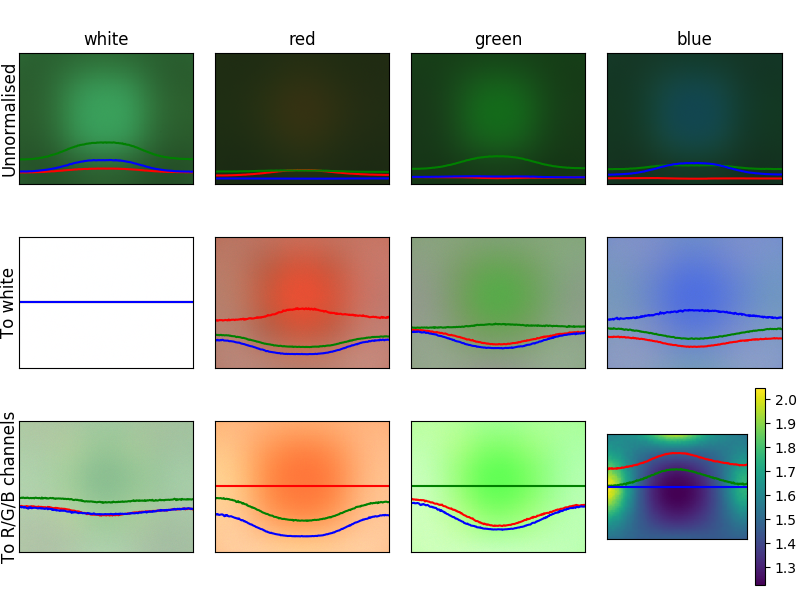

In [77]:
norm_white = 255./binned_images[0]
norm_single = np.zeros_like(norm_white)
for i in range(3):
    norm_single[:,:,i] = 255./binned_images[i+1][:,:,i]
    
def imshow_with_section(ax, image, clip=True):
    """Convert an image to 8 bit and display it in the axes.  Overlay sections through the middle.
    
    if clip==True (default) pixels are constrained to 0-255, to avoid overflow.
    """
    if clip:
        clipped_image = image.copy()
        clipped_image[clipped_image<0] = 0
        clipped_image[clipped_image>255] = 255
    else:
        clipped_image = image
    ax.imshow(clipped_image.astype(np.uint8), origin="bottom")
    x = np.arange(image.shape[1])
    h = image.shape[0]
    for i, col in enumerate(["red","green","blue"]):
        ax.plot(x, image[h//2, :, i]/255.0*h/2.0, color=col)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

fig, ax = plt.subplots(3, 4, figsize=(8,6))
for i, (rgb, image) in enumerate(zip(illuminations, binned_images)):
    imshow_with_section(ax[0,i], image)
    imshow_with_section(ax[1,i], image*norm_white)
    imshow_with_section(ax[2,i], image*norm_single*(0.5 if i==0 else 1.0))
wrgb_col_titles(ax[0,:])
row_titles(ax[:,0],["Unnormalised","To white","To R/G/B channels"])
fig.tight_layout()

After normalising to equalise the intensity of the different channels, we start to see red, green, and blue images for single-colour illumination.  However, crosstalk between the colour channels is clearly much worse at the edges of the images.  We can try to correct for this by using a linear model - what we want is a 3x3 matrix for each pixel in our image (binned here for simplicity and noise reduction).  The forward model would just be the R,G,B values obtained for each of R,G,B illumination.  That is quite simple to do:

In [33]:
crosstalk_matrices = np.stack(binned_images[1:], axis=3)/255.0

The indices in this matrix are:
1. y coordinate
2. x coordinate
3. sensor (recorded) colour channel
4. illumination (true) colour channel

What we want to do now is invert each matrix (there are a few of them!) to create a transformation that will recover the colours, assuming crosstalk is only linear (which ought to be a good assumption.  This may take some time!

In [34]:
compensation_matrices = np.empty_like(crosstalk_matrices)
for i in range(crosstalk_matrices.shape[0]):
    for j in range(crosstalk_matrices.shape[1]):
        compensation_matrices[i,j,:,:] = np.linalg.inv(crosstalk_matrices[i,j,:,:])

In this resulting matrix, indices 3 and 4 are swapped, so 3 corresponds to the true colour channel and 4 matches with the recorded colour channel.  Now, for each of our input illuminations, we should be able to recover a nicely corrected image.  I've written out the matrix multiplications as a product and a sum, because that avoids a for loop.  This is mathematically identical to multiplying each RGB pixel value by the 3x3 correction matrix for that pixel.

<IPython.core.display.Javascript object>


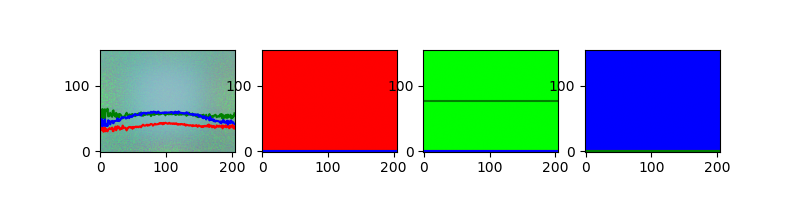

In [58]:
fig, ax = plt.subplots(1, 4, figsize=(8,2))
for i, (rgb, image) in enumerate(zip(illuminations, binned_images)):
    output = np.sum(compensation_matrices * image[:,:,np.newaxis,:], axis=-1)
    imshow_with_section(ax[i], output)
    
wrgb_col_titles(ax[0,:])
fig.tight_layout()

<IPython.core.display.Javascript object>


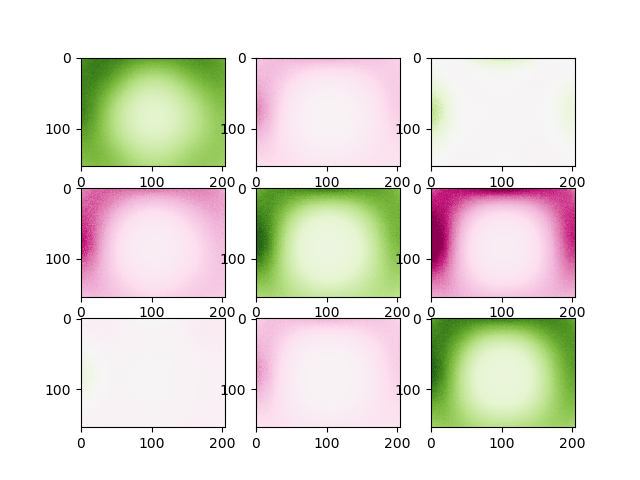

In [50]:
fig, ax = plt.subplots(3,3)
r = max(compensation_matrices.max(), -compensation_matrices.min())
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(compensation_matrices[:,:,i,j], vmin=-r*0.7, vmax=r*0.7, cmap="PiYG")

My guess is that the white image looks really noisy because the noise in the individual R/G/B images is being cancelled out by the per-pixel compensation matrices.  Perhaps it would be better to smooth those matrices quite agressively, so that camera noise remains camera noise...

<IPython.core.display.Javascript object>


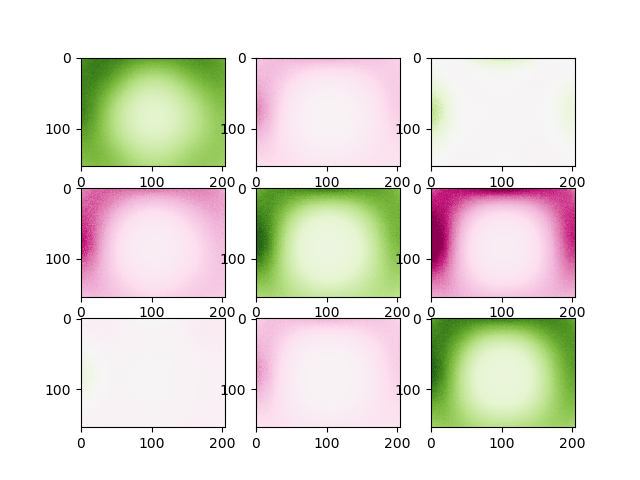

In [51]:
import scipy.ndimage as ndimage
smoothed_compensation = ndimage.gaussian_filter(compensation_matrices, (1,1,0,0), order=0)

fig, ax = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(compensation_matrices[:,:,i,j], vmin=-r*0.7, vmax=r*0.7, cmap="PiYG")

That should increase the noise on the colour channel images, and improve the noise (a little) on the white image.

<IPython.core.display.Javascript object>


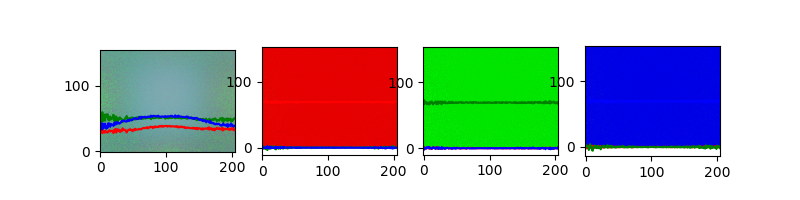

In [57]:
fig, ax = plt.subplots(1, 4, figsize=(8,2))
for i, (rgb, image) in enumerate(zip(illuminations, binned_images)):
    output = np.sum(smoothed_compensation * image[:,:,np.newaxis,:], axis=-1)
    imshow_with_section(ax[i], output*0.9)
    
wrgb_col_titles(ax[0,:])
fig.tight_layout()

For a summary, I've plotted unnormalised, the two possible normalisations (which could be done with a revised lens shading table) and the full correction (which would require post-processing or some other solution that's not in the current pipeline.)

<IPython.core.display.Javascript object>


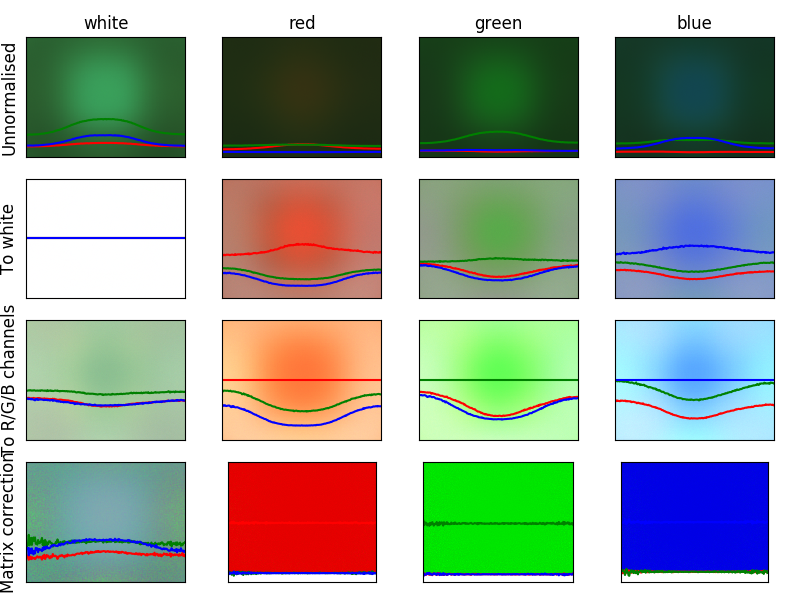

In [78]:
fig, ax = plt.subplots(4, 4, figsize=(8,6))
for i, (rgb, image) in enumerate(zip(illuminations, binned_images)):
    imshow_with_section(ax[0,i], image)
    imshow_with_section(ax[1,i], image*norm_white)
    imshow_with_section(ax[2,i], image*norm_single*(0.5 if i==0 else 1.0))
    output = np.sum(smoothed_compensation * image[:,:,np.newaxis,:], axis=-1)
    imshow_with_section(ax[3,i], output*0.9)
wrgb_col_titles(ax[0,:])
row_titles(ax[:,0],["Unnormalised","To white","To R/G/B channels","Matrix correction"])
fig.tight_layout()

The SNR of the image will go up with the matrix correction - this is visible in the white image in the bottom row.  Of course it's possible to trade off colour fidelity against noise (going from either of the middle rows to the bottom row) but that's just a question of aesthetics.  We can, however, quantify the SNR by making some assumptions:
* There is equal noise on each channel of the image
* The noise on colour channels is independent and identically distributed
For each output colour channel, the *noise* will be the input noise, multiplied by $\sqrt{\sum_iM_{ij}^2$ for each row of the matrix.  The *signal* is a tricky thing to define, but I suspect it doesn't change.  NB there's a factor of 255 in the way I defined the matrix.  This means we can define the change in SNR by evaluating the sum above for each colour channel.  To normalise, I'll divide through by the sum of the diagnoal elements.

<IPython.core.display.Javascript object>


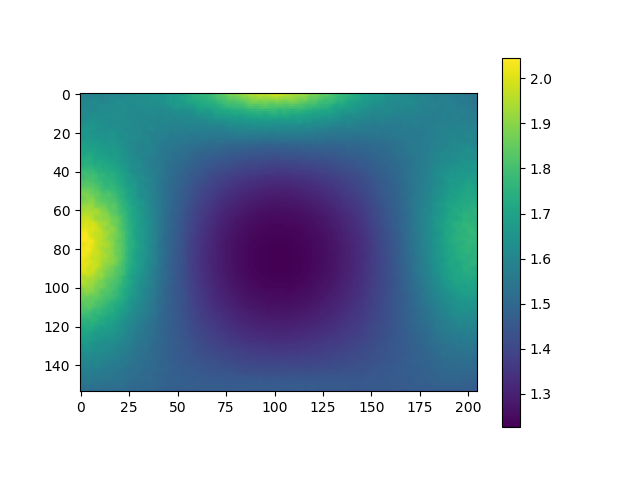

In [81]:
snr_image = np.sum(np.sum(smoothed_compensation**2, axis=-1), axis=-1)
snr_image /= np.sum(np.diagonal(smoothed_compensation**2,axis1=2,axis2=3),axis=-1)

plt.figure()
plt.imshow(snr_image)
plt.colorbar()